# Modelo de reconocimiento de emociones
dataset: https://www.kaggle.com/datasets/msambare/fer2013/

In [115]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [116]:
train_data = 'C:\\Users\\AGUSTINA\\OneDrive\\Documentos\\GitHub\\Reconocimiento-de-emociones\\FER-2013\\train'
test_data = 'C:\\Users\\AGUSTINA\\OneDrive\\Documentos\\GitHub\\Reconocimiento-de-emociones\\FER-2013\\test'

In [117]:
classes = clases = os.listdir(train_data)
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [118]:
#agrego las labels y hago el preprocesamiento de los datos
def add_label (data):
    images = []
    labels = []
    for clas in classes:
        class_path = os.path.join(data, clas)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path)

            #transformo a la imagen en un array de numpy
            image = np.array(image)
            
            images.append(image)
            labels.append(clas)

    return images, labels

In [119]:
X_train, y_train = add_label(train_data)
X_test, y_test = add_label(test_data)

In [120]:
#Función para ver la cantidad de muestras por clase
def plot_classes(y):
    class_freq = Counter(y)
    clases = list(class_freq.keys())
    cantidades = list(class_freq.values())

    plt.figure(figsize=(8, 6))
    plt.bar(clases, cantidades, color='skyblue')
    plt.xlabel('Clases')
    plt.ylabel('Cantidad de muestras')
    plt.title('Cantidad de muestras por clase')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

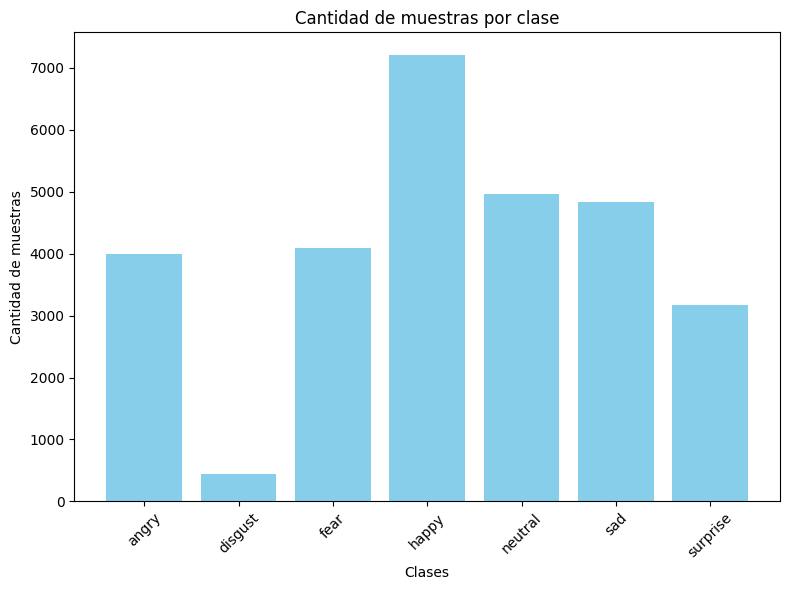

In [121]:
plot_classes(y_train)

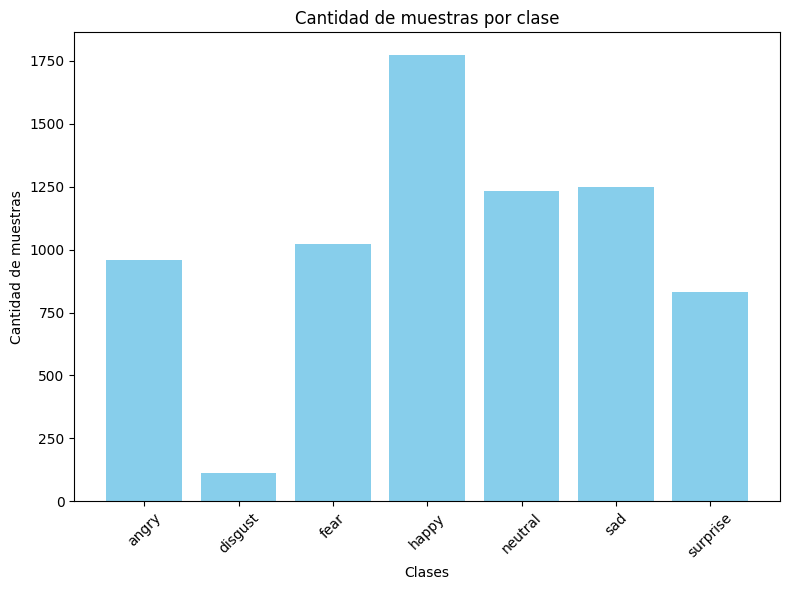

In [122]:
plot_classes(y_test)

In [123]:
#Transformo las X en arrays de numpy
X_train = np.array(X_train)
X_test = np.array(X_test)

#Encodeo los nombres de las clases en números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

#Hago one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [124]:
#Data augmentation para la clase disgust
def disgust_data_augmentation(X, y):
    disgust_index = np.where(y == "disgust")[0]
    disgust_samples = X[disgust_index]

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for i in range(len(disgust_samples)):
        sample = disgust_samples[i]
        sample = sample.reshape((1,) + sample.shape) 

        for batch in datagen.flow(sample, batch_size=1):
            X = np.vstack((X, batch[0]))
            break 

    new_disgust_labels = np.full(len(disgust_samples), "disgust")
    y = np.append(y, new_disgust_labels)

    return X, y

In [125]:
disgust_data_augmentation(X_train, y_train)
disgust_data_augmentation(X_test, y_test)

(array([[[ 46,  34,  26, ...,  10,  13,  22],
         [ 50,  28,  21, ...,  11,  10,  21],
         [ 50,  27,  15, ...,  22,  24,  22],
         ...,
         [208, 179, 108, ..., 191, 205, 204],
         [212, 198, 149, ..., 181, 200, 204],
         [208, 201, 171, ..., 165, 180, 189]],
 
        [[ 55,  33,  54, ...,  40,  42,  52],
         [ 43,  42,  36, ...,  62,  75,  85],
         [ 45,  54,  18, ...,  84, 102, 111],
         ...,
         [242, 240, 242, ..., 152, 177, 186],
         [244, 242, 242, ..., 117, 183, 193],
         [245, 242, 245, ..., 132, 163, 187]],
 
        [[123, 123, 126, ...,  52,  46,  43],
         [116, 115, 116, ...,  52,  49,  51],
         [105, 107, 109, ...,  57,  57,  60],
         ...,
         [ 96,  98,  97, ...,   1,   2,   3],
         [ 87,  90,  90, ...,   1,   2,   1],
         [ 78,  81,  84, ...,   4,   4,   3]],
 
        ...,
 
        [[ 68,  79,  89, ...,  77,  72,  69],
         [ 80,  95, 106, ...,  79,  69,  69],
         [ 90,

In [126]:
X_train.shape

(28709, 48, 48)

In [127]:
model = tf.keras.models.Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(8, activation='relu'),
    
    Dense(7, activation='softmax')
])


In [128]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [129]:
#Me separo una parte de los datos de test para validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [131]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

val_accuracy = history.history['val_accuracy']
print("Validation Accuracy:", val_accuracy)

Epoch 1/10
898/898 [==============================] - 31s 34ms/step - loss: 1.4302 - accuracy: 0.4385 - val_loss: 1.3733 - val_accuracy: 0.4698
Epoch 2/10
898/898 [==============================] - 34s 38ms/step - loss: 1.3701 - accuracy: 0.4733 - val_loss: 1.3525 - val_accuracy: 0.4851
Epoch 3/10
898/898 [==============================] - 34s 38ms/step - loss: 1.3148 - accuracy: 0.4985 - val_loss: 1.3386 - val_accuracy: 0.4943
Epoch 4/10
898/898 [==============================] - 34s 38ms/step - loss: 1.2623 - accuracy: 0.5199 - val_loss: 1.2842 - val_accuracy: 0.5060
Epoch 5/10
898/898 [==============================] - 32s 35ms/step - loss: 1.2219 - accuracy: 0.5351 - val_loss: 1.2790 - val_accuracy: 0.5199
Epoch 6/10
898/898 [==============================] - 17s 19ms/step - loss: 1.1763 - accuracy: 0.5559 - val_loss: 1.2536 - val_accuracy: 0.5341
Epoch 7/10
898/898 [==============================] - 17s 19ms/step - loss: 1.1280 - accuracy: 0.5732 - val_loss: 1.2632 - val_accuracy:

In [132]:
#Pruebo con test
test_loss, test_acc = model.evaluate(X_test, y_test)

113/113 [==============================] - 1s 7ms/step - loss: 1.3051 - accuracy: 0.5171
